<a href="https://colab.research.google.com/github/Hamid-GHub/Introduction-to-Deep-Leaning-Course-Week-5-Assignment/blob/main/Introduction_to_Deep_Learning_Week_5_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Generative Adversarial Networks for Monet Paintings**

## **Project Description**

The Monet paintings have a unique style. Without having Claude Monet it might be  difficult to repeat his painting style for the new scenes. The goal of this project is to apply the style of Monet painting to a new given photo so that it look like it has been painted by Claude Monet. This project uses special type Generative Adversarial Networks (GAN) called CycleGAN which is mainly used for image traslation.



## **Generative Deep Learning Models**
Generative Models are kind of unsupervised models that are trained to mimic the patterns in a dataset and produce examples very similar to those of training set.
Generative models comprised of two sub-models. These two submodels are called generators and discriminators. The role of the generator is to make fake example that look like the real example. On the other hand, the role of discriminator is to distinguish the real example from the fake example. These two sub-models compete with each other up to the point when a balance between them established.

In [1]:
#installing kaggle as a prerequisite for downloading the dataset from Kaggle.com 
! pip install -q kaggle

! rm -rf ~/.kaggle
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [2]:
#Downloading the dataset
! kaggle competitions download -c gan-getting-started 
! rm -rf gan-getting-started
! unzip -q gan-getting-started.zip -d gan-getting-started #unzip

100% 367M/367M [00:16<00:00, 25.4MB/s]
100% 367M/367M [00:16<00:00, 22.9MB/s]


In [3]:
!pip install tensorflow_addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.3 MB/s eta 0:00:00


In [4]:
# importing required libraries
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import tensorflow_addons  as tfa
import pickle
import PIL
import os
import shutil
import random

## **Data**
In this section some descriptions of dataset is provided.

### **Size**
The photo part has 7038 examples and Monet part has 300 examples.

### **Dimension**
Each example either in monet or photo part has $ 256 \times 256 \times 3 $ dimensions where first 256 is height, second 256 is width and 3 is the number of color channels (i.e. red, green, blue)

### **Structure**

The whole dataset is structured in four (4) different folders. There are two folders in .jpg format for Monet and photo. In addition, there are two folders in .tfrec format for Monet and photo. Examples with JPG format are same as examples with TFREC formats.



In [5]:
HEIGHT = 256
WIDTH  = 256
CHANNELS =3
MONET_PATH_TFREC = '/content/gan-getting-started/monet_tfrec'
PHOTO_PATH_TFREC = '/content/gan-getting-started/photo_tfrec'

MONET_PATH_JPG = '/content/gan-getting-started/monet_jpg'
PHOTO_PATH_JPG = '/content/gan-getting-started/photo_jpg'
BATCH_SIZE =1

In [6]:
# saving the names of all the files with .tfrec format in a list
monet_filenames = tf.io.gfile.glob(MONET_PATH_TFREC+'/*.tfrec')
photo_filenames = tf.io.gfile.glob(PHOTO_PATH_TFREC+'/*.tfrec')

In [7]:
# saving the names of all the files with .jpg format in a list
monet_filenames_jpg = tf.io.gfile.glob(MONET_PATH_JPG+'/*.jpg')
photo_filenames_jpg = tf.io.gfile.glob(PHOTO_PATH_JPG+'/*.jpg')

# checking the number of monet examples and photo examples
monet_len = len(monet_filenames_jpg)
photo_len = len(photo_filenames_jpg)

print(monet_len)
print(photo_len)

300
7038


In [8]:
#loading an image files by its path
def load_image(path):
   img = tf.io.read_file(path)
   img = tf.image.decode_image(img,channels =3)
   img = tf.image.convert_image_dtype(img, tf.float32)
   img = tf.reshape(img, [HEIGHT, WIDTH, CHANNELS])
   return img


## **Exploratory Data Analysis**

This sections explores the datasets by plotting some training examples. In addition, some histograms for different color channels in the training set are displayed.

In [9]:
#The function below decode image, rescales and reshape The,
def decode_image(record):

   img = tf.image.decode_image(record,channels =3)
   img = (tf.cast(img, tf.float32)/127.5)-1
   img = tf.reshape(img, [HEIGHT, WIDTH, CHANNELS])

   return img

#This function preprocess and then decode the image.
def process_record(record):

    format = {
       'image_name': tf.io.FixedLenFeature([],tf.string),\
       'image': tf.io.FixedLenFeature([],tf.string),\
       'target': tf.io.FixedLenFeature([],tf.string) }

    record = tf.io.parse_single_example(record, format)
    image = decode_image(record['image'])


    return image
    

In [10]:
#loads the whole dataset (either Monet or photo) to a tensorflow dataset object
def load_dataset(filenames):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(process_record, num_parallel_calls =tf.data.experimental.AUTOTUNE)
    return dataset

In [11]:
monet_dataset = load_dataset(monet_filenames).batch(BATCH_SIZE)
photo_dataset = load_dataset(photo_filenames).batch(BATCH_SIZE)

### **Visulaization of Some Images from Monet Class**

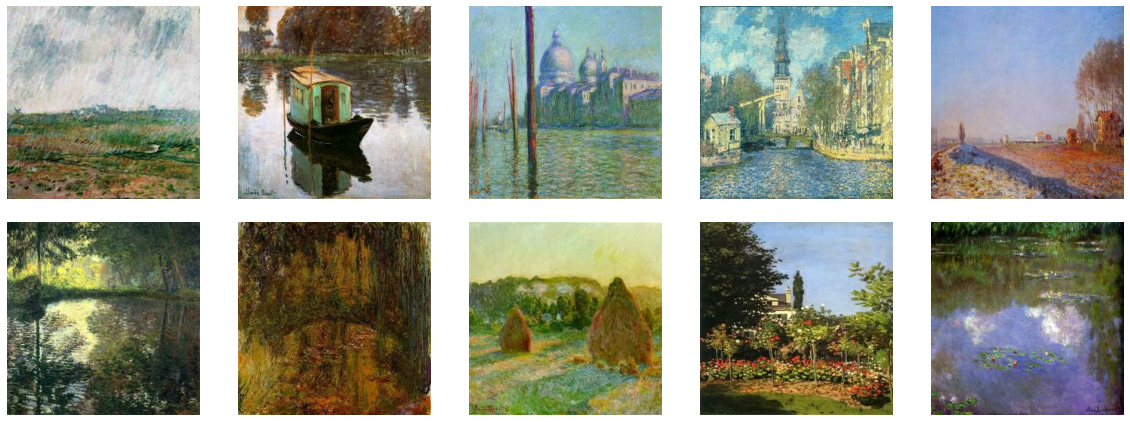

In [12]:
#plotting some examples from Monet class
_,ax = plt.subplots(2,5,figsize = (20,20))
plt.subplots_adjust(bottom = 0.4, top =0.7, hspace =0)
sample_monet_dataset = random.sample(monet_filenames_jpg,10)
for index, filename in enumerate(sample_monet_dataset):
    image = load_image(filename)
    ax[index//5,index%5].imshow(image)
    # ax[index//5,index%5].set_title('input photo')
    ax[index//5,index%5].axis('off')

### **Visulaization of Some Images from Photo Class**

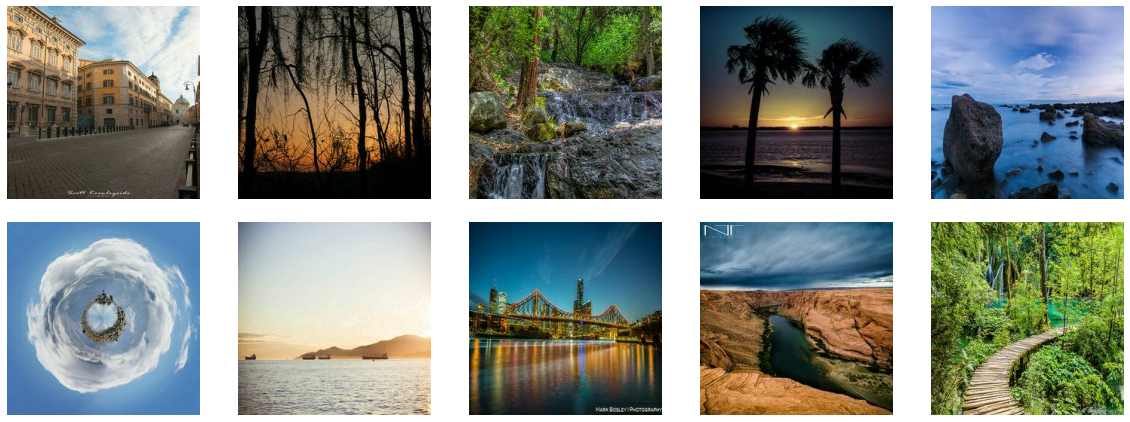

In [13]:
#plotting some photo examples
_,ax = plt.subplots(2,5,figsize = (20,20))
plt.subplots_adjust(bottom = 0.4, top =0.7, hspace =0)
sample_monet_dataset = random.sample(photo_filenames_jpg,10)
for index, filename in enumerate(sample_monet_dataset):
    image = load_image(filename)
    ax[index//5,index%5].imshow(image)
    # ax[index//5,index%5].set_title('input photo')
    ax[index//5,index%5].axis('off')

### **Histograms of Color Channels for Monet Class**

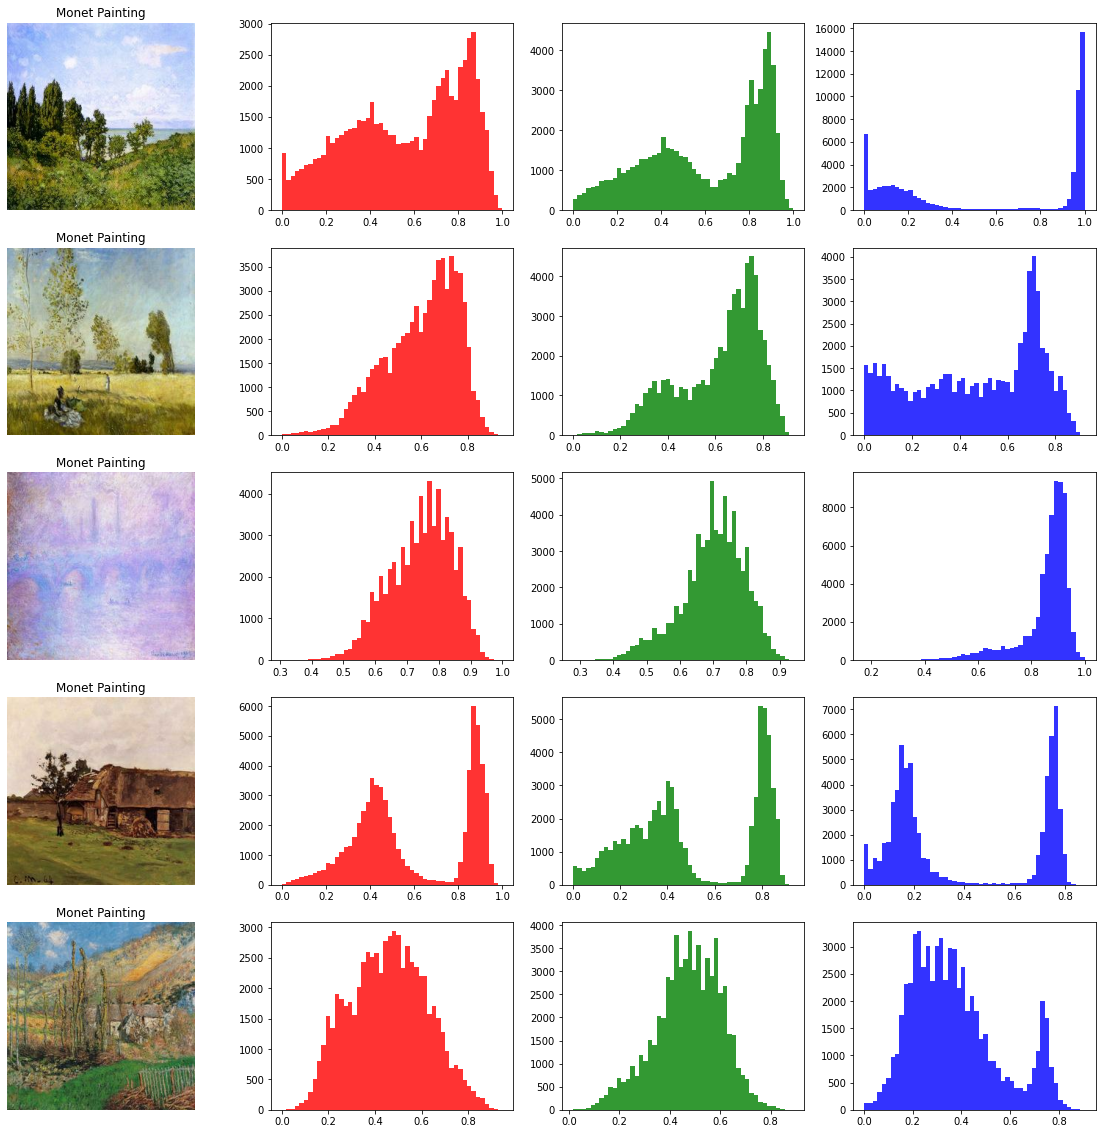

In [15]:
#plotting some Monet paintings along with their histogram of red, green and blue channels

sample_monet_dataset = random.sample(monet_filenames_jpg,5)

_,ax = plt.subplots(5,4,figsize = (20,20))

for index, filename in enumerate(sample_monet_dataset):
    image = load_image(filename).numpy()
    ax[index,0].imshow(image)
    ax[index,0].set_title('Monet Painting')
    ax[index,0].axis('off')
    
    ax[index,1].hist(image[:,:,0].reshape(-1),bins=50, alpha = 0.8,color ='red')
    ax[index,2].hist(image[:,:,1].reshape(-1),bins=50, alpha = 0.8,color ='green')
    ax[index,3].hist(image[:,:,2].reshape(-1),bins=50, alpha = 0.8,color ='blue')

### **Histograms of Color Channels for Photo Class**

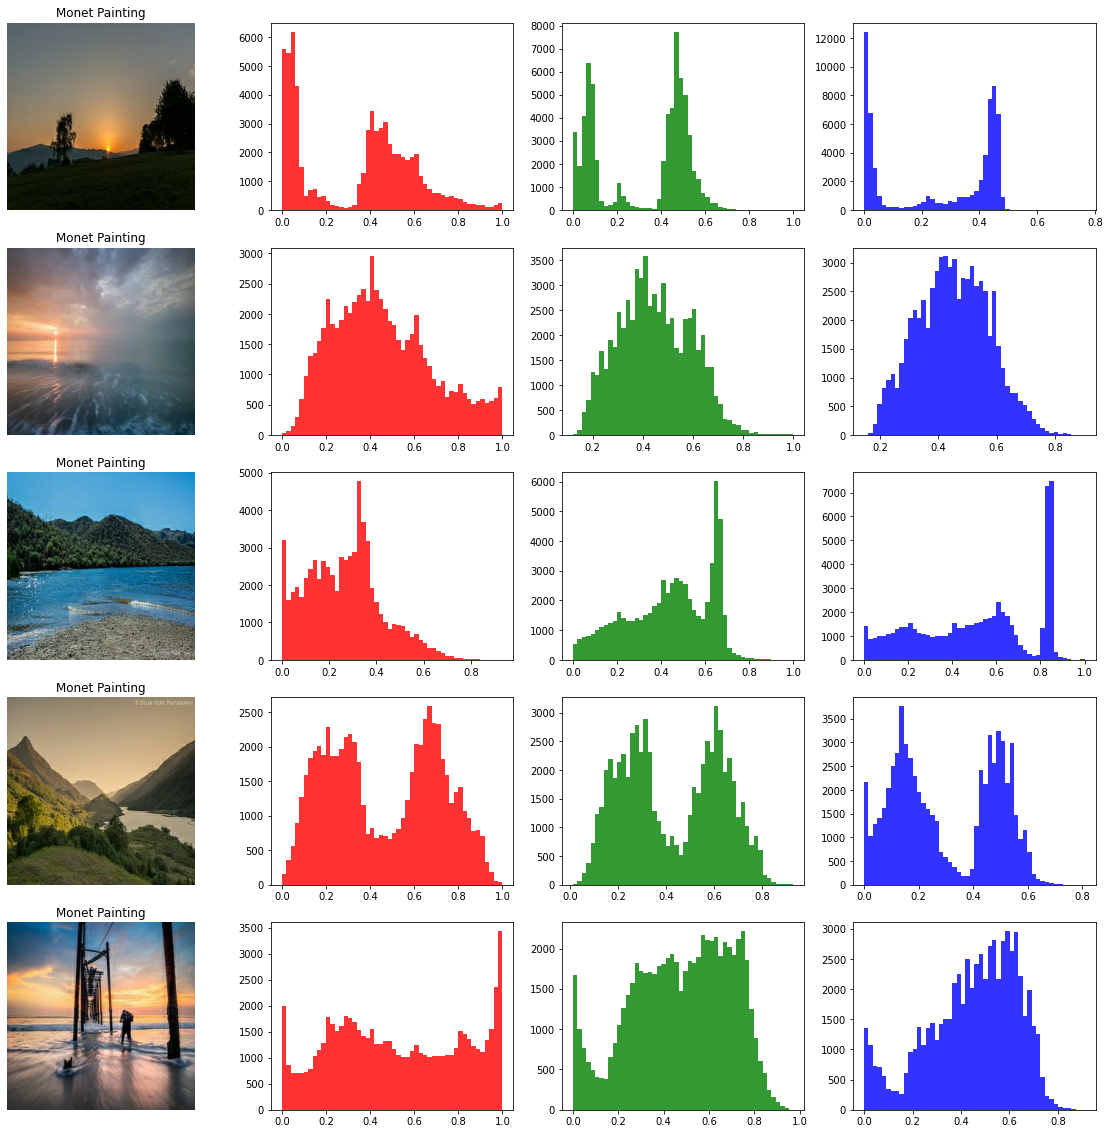

In [16]:
#plotting some photos along with their histogram of red, green and blue channels
sample_photo_dataset = random.sample(photo_filenames_jpg,5)

_,ax = plt.subplots(5,4,figsize = (20,20))

for index, filename in enumerate(sample_photo_dataset):
    image = load_image(filename).numpy()
    ax[index,0].imshow(image)
    ax[index,0].set_title('Monet Painting')
    ax[index,0].axis('off')
    
    ax[index,1].hist(image[:,:,0].reshape(-1),bins=50, alpha = 0.8,color ='red')
    ax[index,2].hist(image[:,:,1].reshape(-1),bins=50, alpha = 0.8,color ='green')
    ax[index,3].hist(image[:,:,2].reshape(-1),bins=50, alpha = 0.8,color ='blue')

## **Model Architecture**

**Used Architecture**

The architecture chosen for this project is **CycleGAN**.

**Explanation for choosing CycleGAN**

The reason for choosing CycleGAN model is its unpaired property. In unpaired model, for translating images in domain A to domain B, it is not necessary to have corresponding image in domain B for each image in domain A.

**Hyperparameter Tuning:**

The hyperparemeter tuning for the chosen model could be performed by using the advice from experts or in trial-and-error fashion.


In [17]:
#This function reduces the 2D dimensions of an image
def downsample(filters, size, instance_norm = True):

  initializer = tf.random_normal_initializer(0,0.02)
  gamma = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Conv2D(filters, size, strides =2, padding ='same', kernel_initializer = initializer, use_bias = False ))
  if instance_norm:
    model.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma))
  model.add(tf.keras.layers.LeakyReLU())
  return model

In [18]:
#This function increases the 2D dimensions of an image
def upsample(filters, size, dropout  = True):

   initializer = tf.random_normal_initializer(0,0.02) 
   gamma = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)

   model = tf.keras.Sequential()
   model.add(tf.keras.layers.Conv2DTranspose(filters, size, strides =2 ,padding ='same', kernel_initializer = initializer, use_bias = False   ))

   model.add(tfa.layers.InstanceNormalization(gamma_initializer = gamma))

   if dropout:
     model.add(tf.keras.layers.Dropout(0.5))

   model.add(tf.keras.layers.ReLU())

   return model

In [19]:
#This function defines the generator submodels with a series of downsampling and upsampling blocks
def generator():
  inputs = tf.keras.layers.Input(shape = [HEIGHT, WIDTH, CHANNELS] )

  down_stack = [
       downsample(64,4, instance_norm =False),
       downsample(128,4),
       downsample(256,4),
       downsample(512,4),
       downsample(512,4),
       downsample(512,4),
       downsample(512,4),
       downsample(512,4)
       ]

  up_stack = [
      
      upsample(512,4, dropout = True),
      upsample(512,4, dropout = True),
      upsample(512,4, dropout = True),
      upsample(512,4),
      upsample(256,4),
      upsample(128,4),
      upsample(64,4),
      
  ]

  initializer = tf.random_normal_initializer(0,0.02)

  last = tf.keras.layers.Conv2DTranspose(CHANNELS, 4, strides =2 ,padding ='same', kernel_initializer = initializer, activation  ='tanh'  )
  
  x = inputs
  skips = []

  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  for up, skip in zip(up_stack, skips):
    x=up(x)
    x = tf.keras.layers.Concatenate() ([x, skip])

  x =  last(x)

  return tf.keras.Model (inputs = inputs , outputs =x )


In [20]:
# This function defines the discriminator submodel with a series of downsampling blocks.
def discriminator():
    initializer = tf.random_normal_initializer(0,0.02)
    gamma = tf.keras.initializers.RandomNormal(mean = 0, stddev = 0.02)

    inputs = tf.keras.layers.Input(shape =  [HEIGHT, WIDTH, CHANNELS] )
    

    x = downsample(64, 4, False) (inputs)
    x = downsample(128,4) (x)
    x = downsample(256,4) (x)

    x = tf.keras.layers.ZeroPadding2D()(x)
    x = tf.keras.layers.Conv2D(512, 4, strides =1 , kernel_initializer = initializer, use_bias = False   ) (x)

    x = tfa.layers.InstanceNormalization(gamma_initializer = gamma)(x)

    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.ZeroPadding2D()(x)

    x = tf.keras.layers.Conv2D(1, 4, strides =1 , kernel_initializer = initializer ) (x)

    return tf.keras.Model(inputs = inputs, outputs = x )


In [21]:
#Two generators, one for generating a Monet painting and one for generating a photo are defined.
monet_generator = generator()
photo_generator = generator()

In [22]:
#Two discriminators, one for distinguishing a real Monet painting from the fake one and one for distinguishing a real photo from the fake one are defined.
monet_discriminator = discriminator()
photo_discriminator = discriminator()

In [23]:
# The whole model is defined as CyclaGAN class below using Tensorflow model subclassing API.
class CycleGAN(tf.keras.Model):

      def __init__(self, monet_gen, photo_gen, monet_dis, photo_dis, lambda_cycle =10 ):
        super(CycleGAN, self).__init__()
        self.monet_gen = monet_gen
        self.photo_gen = photo_gen
        self.monet_dis = monet_dis
        self.photo_dis = photo_dis
        self.lambda_cycle = lambda_cycle
      
      def compile(self, monet_gen_optimizer, photo_gen_optimizer, monet_dis_optimizer,
                  photo_dis_optimizer, gen_loss_fn, dis_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGAN, self).compile()
        self.monet_gen_optimizer =  monet_gen_optimizer
        self.photo_gen_optimizer =  photo_gen_optimizer
        self.monet_dis_optimizer =  monet_dis_optimizer
        self.photo_dis_optimizer =  photo_dis_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.dis_loss_fn =  dis_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

      def train_step(self,batch_data):
          real_monet,real_photo = batch_data

          with tf.GradientTape(persistent= True) as tape:
               fake_monet   = self.monet_gen(real_photo,training =True)

               cycled_photo = self.photo_gen(fake_monet, training = True)


               fake_photo   = self.photo_gen(real_monet, training = True)
               cycled_monet = self.monet_gen(fake_photo, training = True)

               same_monet = self.monet_gen(real_monet, training = True)
               same_photo = self.photo_gen(real_photo, training =True)

               dis_real_monet = self.monet_dis(real_monet, training = True)
               dis_real_photo = self.photo_dis(real_photo, training = True)

               dis_fake_monet =  self.monet_dis(fake_monet, training = True)
               dis_fake_photo =  self.photo_dis(fake_photo, training = True)

               monet_gen_loss = self.gen_loss_fn(dis_fake_monet)
               photo_gen_loss = self.gen_loss_fn(dis_fake_photo)

               total_cycle_loss = self.cycle_loss_fn(real_monet,cycled_monet , self.lambda_cycle) \
                                  + self.cycle_loss_fn(real_photo, cycled_photo,self.lambda_cycle)
               
               total_monet_gen_loss = monet_gen_loss + total_cycle_loss +self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)

               total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo,self.lambda_cycle)

               monet_dis_loss = self.dis_loss_fn(dis_real_monet, dis_fake_monet)
               photo_dis_loss = self.dis_loss_fn(dis_real_photo, dis_fake_photo)


          monet_gen_grad = tape.gradient(total_monet_gen_loss, self.monet_gen.trainable_variables)
          photo_gen_grad = tape.gradient(total_photo_gen_loss, self.photo_gen.trainable_variables)

          monet_dis_grad = tape.gradient(monet_dis_loss, self.monet_dis.trainable_variables)
          photo_dis_grad = tape.gradient(photo_dis_loss, self.photo_dis.trainable_variables)

          self.monet_gen_optimizer.apply_gradients(zip(monet_gen_grad, self.monet_gen.trainable_variables))
          self.photo_gen_optimizer.apply_gradients(zip(photo_gen_grad, self.photo_gen.trainable_variables))

          self.monet_dis_optimizer.apply_gradients(zip(monet_dis_grad,self.monet_dis.trainable_variables ))
          self.photo_dis_optimizer.apply_gradients(zip(photo_dis_grad, self.photo_dis.trainable_variables))


          return { 'monet_gen_loss': total_monet_gen_loss , \
                  'photo_gen_loss': total_photo_gen_loss,\
                  'monet_dis_loss': monet_dis_loss,\
                  'photo_dis_loss': photo_dis_loss
                  
                  
                  }


In [24]:
#calculates the discriminator loss as defined by CycleGAN paper
def discriminator_loss(real,generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits =True, reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(real),real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits =True, reduction = tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated),generated)

    total_loss = (real_loss + generated_loss)*0.5

    return total_loss

    

In [25]:
#calculates the generator loss as defined by CycleGAN paper
def generator_loss(generated):
   return tf.keras.losses.BinaryCrossentropy(from_logits =True, reduction = tf.keras.losses.Reduction.NONE)(tf.ones_like(generated),generated)

In [26]:
#Caclulates the cycle loss which is the difference between original image and converted back image or Monet painting and converted back Monet painting.
def cycle_loss(real_image, cycled_image, lambda_):
    return lambda_* tf.reduce_mean(tf.abs(real_image-cycled_image))

In [27]:
# Calculates the difference between a photo and a photo converted from a photo or difference between
# a Monet painting and a Monet painting converted from a Monet painting
def identity_loss(real_image, same_image, lambda_):
    return lambda_* 0.5 * tf.reduce_mean(tf.abs(real_image-same_image)) 

In [28]:
#Adam optimizer is selected as optimizer for generators and discriminators
monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

monet_dis_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
photo_dis_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

In [29]:
#instantiating a CycleGAN model with two generators and two discriminators defined above.
cycle_gan = CycleGAN(monet_generator, photo_generator, monet_discriminator, photo_discriminator)
cycle_gan.compile(monet_gen_optimizer = monet_gen_optimizer , photo_gen_optimizer = photo_gen_optimizer , monet_dis_optimizer = monet_dis_optimizer,
                  photo_dis_optimizer = photo_dis_optimizer, gen_loss_fn = generator_loss, dis_loss_fn = discriminator_loss, \
                  cycle_loss_fn = cycle_loss, identity_loss_fn = identity_loss)

In [30]:
#training the CycleGAN model on Monet and Photo dataset for 15 epochs
history = cycle_gan.fit(tf.data.Dataset.zip((monet_dataset,photo_dataset)), epochs =15)

Epoch 1/15
300/300 [==============================] - 182s 447ms/step - monet_gen_loss: 5.2755 - photo_gen_loss: 5.4033 - monet_dis_loss: 0.6210 - photo_dis_loss: 0.6173
Epoch 2/15
300/300 [==============================] - 137s 458ms/step - monet_gen_loss: 3.7966 - photo_gen_loss: 3.8373 - monet_dis_loss: 0.6409 - photo_dis_loss: 0.6307
Epoch 3/15
300/300 [==============================] - 139s 462ms/step - monet_gen_loss: 3.6139 - photo_gen_loss: 3.7250 - monet_dis_loss: 0.6539 - photo_dis_loss: 0.6177
Epoch 4/15
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 3.5641 - photo_gen_loss: 3.6855 - monet_dis_loss: 0.6400 - photo_dis_loss: 0.5905
Epoch 5/15
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 3.4269 - photo_gen_loss: 3.5830 - monet_dis_loss: 0.6303 - photo_dis_loss: 0.5917
Epoch 6/15
300/300 [==============================] - 139s 463ms/step - monet_gen_loss: 3.3255 - photo_gen_loss: 3.4753 - monet_dis_loss: 0.6227 - pho

In [32]:
# Saving the trained model on disk

! mkdir -p '/content/drive/MyDrive/saved_models_Intro_to_Deep_Leraning_week_5/'
cycle_gan.save_weights('/content/drive/MyDrive/saved_models_Intro_to_Deep_Leraning_week_5/cycle_gan.h5')

with open('/content/drive/MyDrive/saved_models_Intro_to_Deep_Leraning_week_5/history_history','wb') as file:
  pickle.dump(history.history, file)

In [ ]:
#Loading the trained model from disk
cycle_gan.built = True
cycle_gan.load_weights('/content/drive/MyDrive/saved_models_Intro_to_Deep_Leraning_week_5/cycle_gan')



with open('/content/drive/MyDrive/saved_models_Intro_to_Deep_Leraning_week_5/history_history','rb') as file:
   history_history = pickle.load(file)

In [ ]:
# ! cp '/content/drive/MyDrive/saved_models_Intro_to_Deep_Leraning_week_5/cycle_gan.h5' '/content/drive/MyDrive/saved_models_Intro_to_Deep_Leraning_week_5/cycle_gan' 

## **Results and Analysis** 

The result of evaluation of the model based on MFID (Memorization-informed Frechet Inception Distance) metric is around 69 as denoted by the figure below. The score is not that bad but still can be improved probably by using better combination of hyperparameters or training the model for more number of epochs.











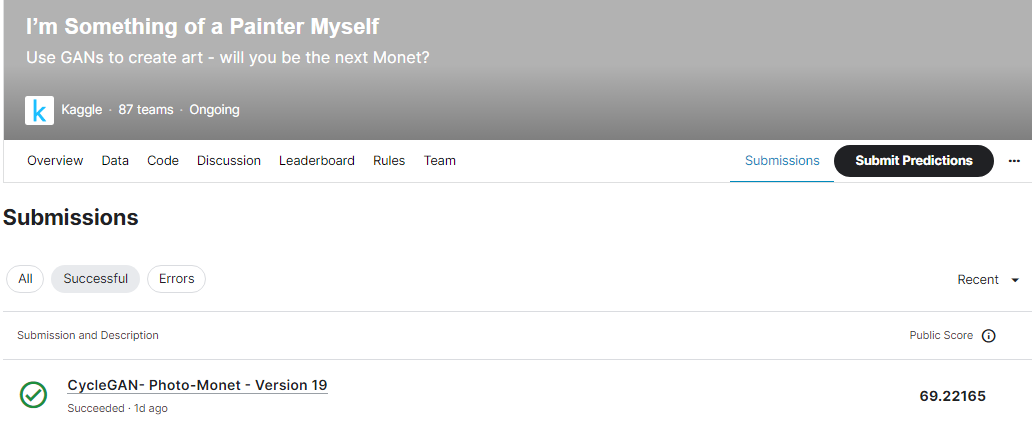

### **Visualization of Some Translated Images**

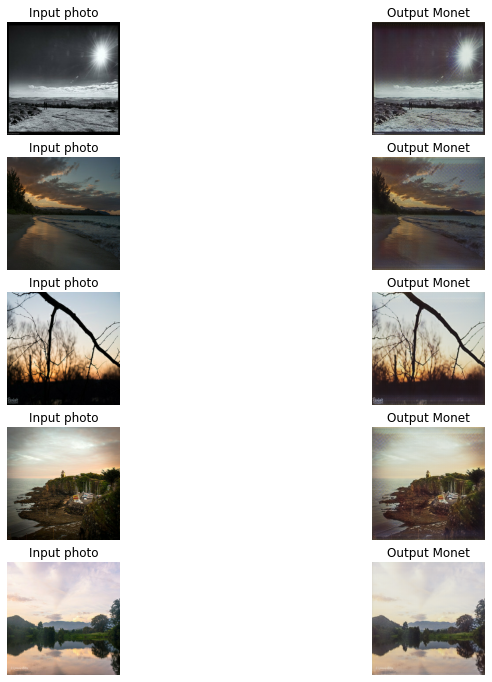

In [33]:
#plotting 5 photos and their translated Monet paintings
_,ax = plt.subplots(5,2,figsize = (12,12))

for index, image in enumerate(photo_dataset.take(5)):
    prediction = monet_generator(image, training = False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    image = (image[0] *127.5 + 127.5).numpy().astype(np.uint8)

    ax[index,0].imshow(image)
    ax[index,0].set_title('Input photo')
    ax[index,0].axis('off')

    ax[index,1].imshow(prediction)
    ax[index,1].set_title('Output Monet')
    ax[index,1].axis('off')


### **Summary for Hyperparameter Tuning**

In short, the hyperparameter tuning for the models like the model in this project should be conducted by taking advantage of advice from experts or should be performed in a trial and error manner.

### **Why Some Hyperparameters Do not work**
The choice of hyperparameter can be specific to an application. A hyperparameter value that works well for a specific problem may not work well for other problem. Thererefore, in practice, it is best to stick with (or start with) set of hyperparameter used by other prominent works carried out for the similar application.

### **Troubleshooting Procedure**
The troubleshooting procedure for enhancing the performance of the current model could be exploring different sets of hyperparameters. In addition, using data augmentation methods might result in a more accurate solution.


## **Conclusion**

### **Summary of results**
The CycleGAN model was evaluated based on MFID (Memorization-informed Frechet Inception) metric and the score was around 69. 

In addition, some translated photos to Monet painting were explored. The translated images still have some room for improvement.
### **Learning and Takeaways**
The main takeaways from this project was validating the applicability of CycleGAN model for style transfer of photo to painting.

### **Suggestion for improving the current**
َA potential improvement for the current work is to use data augmentation methods and then training the CycleGAN model on the augemented data. This hopefully can result in a better solution.

## **Saving the Translated Photos for Submission**

In [34]:
SAVE_PATH = './Monet_output'

if not os.path.exists(SAVE_PATH ):
    os.mkdir(SAVE_PATH )
else:
  shutil.rmtree(SAVE_PATH )
  os.mkdir(SAVE_PATH )

 
for index, photo in enumerate(photo_dataset):

  prediction = monet_generator(photo, training = False)[0].numpy()
  prediction = (prediction * 127.5 + 127.5).astype(np.uint8)

  PIL.Image.fromarray(prediction).save(SAVE_PATH  + f'/image {index+1}.jpg')

shutil.make_archive('images', 'zip', SAVE_PATH )


'/content/images.zip'